In [1]:
import matplotlib.pyplot as plt
import polars as pl
from pathlib import Path
import numpy as np
from typing import List, Tuple
from pprint import pp
import seaborn as sns
import matplotlib as mpl

# plot stuff
sns.set_style("darkgrid")
viridis_cmap = plt.get_cmap("viridis")

# Path to the measurements
DATA_FOLDER = Path("../log")
DATA_FOLDER_TASK_1 = DATA_FOLDER / "task1"
DATA_FOLDER_TASK_2 = DATA_FOLDER / "task2"
# !ls -l $DATA_FOLDER


from matplotlib.legend_handler import HandlerBase

class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):


        if not isinstance(orig_handle[0], tuple):
            orig_handle = [orig_handle]
        print(orig_handle)
        
        lines = [
            plt.Line2D([x0,y0+width], [pos*height,pos*height], color=color, ls=style, linewidth=lw, solid_capstyle='butt', dashes=dashes)
            if dashes is not None else
            plt.Line2D([x0,y0+width], [pos*height,pos*height], color=color, ls=style, linewidth=lw, solid_capstyle='butt')
            for color, style, pos, lw, dashes in orig_handle
        ]


        # l1 = plt.Line2D([x0,y0+width], [0.8*height,0.8*height], color=orig_handle[1][0], ls=orig_handle[1][1], linewidth=5, solid_capstyle='butt')
        # l2 = plt.Line2D([x0,y0+width], [0.5*height,0.5*height], color=orig_handle[1][0], ls=orig_handle[1][1], linewidth=5, solid_capstyle='butt')
        # l3 = plt.Line2D([x0,y0+width], [0.2*height,0.2*height], color=orig_handle[0][0], ls=orig_handle[1][1], linewidth=5, solid_capstyle='butt')

        return lines

In [2]:
measurements_10kB: List[Path] = list(DATA_FOLDER_TASK_1.glob("*10kB.csv"))
measurements_100kB: List[Path] = list(DATA_FOLDER_TASK_1.glob("*100kB.csv"))
measurements_1MB: List[Path] = list(DATA_FOLDER_TASK_1.glob("*1MB.csv"))
measurements_10MB: List[Path] = list(DATA_FOLDER_TASK_1.glob("*10MB.csv"))

In [3]:
"""
Get a bounded list of colors from a colormap
"""
def get_colors_from_cmap(num_colors: int, cmap, color_lims=[], offset=0):
    # if color limits are empty, then use a range proportional to the number of colors
    # the higher the number of colors, the larger the range, approaching the full range of the colormap
    if len(color_lims) == 0:
        percentage_range = (1 - (1 / num_colors)) * 0.75
        color_lims = [0.5 * (1 - percentage_range) + offset, 0.5 * (1 + percentage_range) + offset]

    return [cmap(i) for i in np.linspace(color_lims[0], color_lims[1], num_colors)]

# Make a gradient of colors
def gradient(color: str, n: int) -> List[str]:
    """
    :param color: name of the color e.g. #ff0000
    :param n: number of colors
    """
    
    # Convert to RGB
    r, g, b = int(color[1:3], 16), int(color[3:5], 16), int(color[5:7], 16)
    
    # Make a gradient
    colors = []
    for i in range(n):
        r_i = int(r + (255 - r) * i / n)
        g_i = int(g + (255 - g) * i / n)
        b_i = int(b + (255 - b) * i / n)
        colors.append(f"#{r_i:02x}{g_i:02x}{b_i:02x}")
    return colors[::-1]

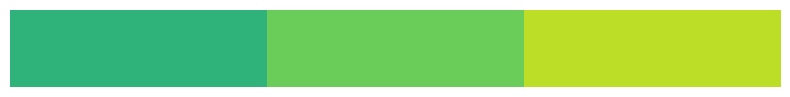

In [4]:
# Test util.get_colors_from_cmap
colors = get_colors_from_cmap(3, viridis_cmap, color_lims=[0.65, 0.9])
# Plot the colors with a square each
fig, ax = plt.subplots(figsize=(10, 1))
ax.imshow([colors], extent=[0, 10, 0, 1])
ax.axis("off")
plt.show()

(('#482475', 'solid', 0.8, 5, None), ('#2fb47c', 'solid', 0.2, 5, None))
(('#3e4a89', 'solid', 0.8, 5, None), ('#6ccd5a', 'solid', 0.2, 5, None))
(('#2f6c8e', 'solid', 0.8, 5, None), ('#bddf26', 'solid', 0.2, 5, None))
[('#090909', 'dashed', 0.5, 2, [3, 1.5])]


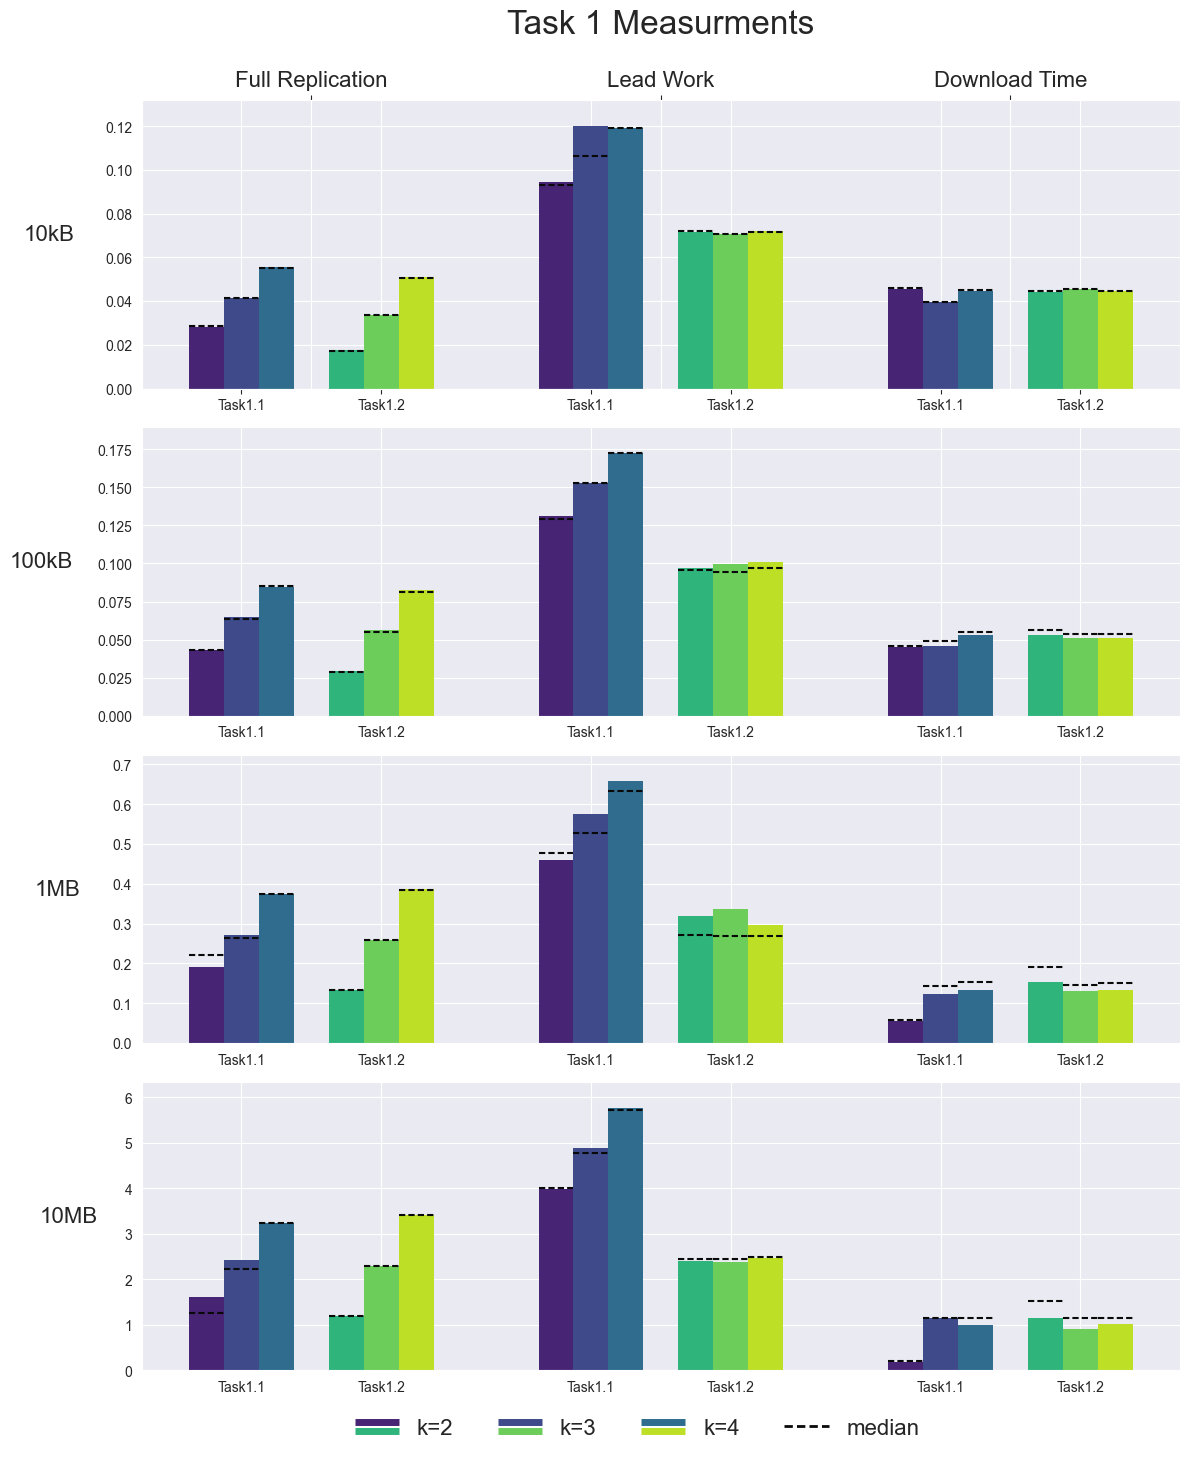

In [5]:
# Read the measurements and group them by the measurement name

ROWS: int = 4
COLS: int = 1
FIGSIZE: Tuple[int, int] = (12, 14)

WIDTH_BAR: float = 0.25

x = np.arange(2)

LABELS = ["Task 1.1", "Task 1.2"]

fig, axs = plt.subplots(ROWS, COLS, figsize=FIGSIZE)

replicas = [2,3,4]

K_COLORS_TASK_1_1 = {
    str(k): color
    # for k, color in zip(replicas, gradient("#802080", len(replicas)))
    for k, color in zip(replicas, get_colors_from_cmap(3, viridis_cmap, color_lims=[0.1, 0.35]))
}
K_COLORS_TASK_1_2 = {
    str(k): color
    # for k, color in zip(replicas, gradient("#802080", len(replicas)))
    for k, color in zip(replicas, get_colors_from_cmap(3, viridis_cmap, color_lims=[0.65, 0.9]))
}

XS = [0, 1, 2.5, 3.5, 5, 6]

y_maxs = []
bars = []

for r, measurements in enumerate([measurements_10kB, measurements_100kB, measurements_1MB, measurements_10MB]):
    y_max = 0

    # 2 * 3 = 6

    for c, (title_name, column_name) in enumerate([
        ("Full Replication", "time_replication"),
        ("Lead Work", "time_lead_total_work"),
        ("Download Time", "time_download")
    ]):
        # Slice XS such that we get index (0,1), (2,3), (4,5)
        xs = XS[c*2:c*2+2]
        # print(xs)

        xs = np.array(xs)

        ax = axs[r]

        # Read the measurements for task1.1 and task1.2
        measurements_task1_1 = list(filter(lambda f: "task1.1" in f.name, measurements))
        measurements_task1_2 = list(filter(lambda f: "task1.2" in f.name, measurements))

        ks = {
            '2': {
                'mean': [],
                'median': [],
                'colors': []
            },
            '3': {
                'mean': [],
                'median': [],
                'colors': []
            },
            '4': {
                'mean': [],
                'median': [],
                'colors': []
            }
        }
        
        # Go through each task (1.1 then 1.2)
        for task in [measurements_task1_1, measurements_task1_2]:
            # For the curren K in the current c,r position
            for f in task:
                # Open file, ignore outliers and calculate mean and median
                k = int(f.name.split("_")[1])

                df = pl.read_csv(f)
                data = df[column_name].to_numpy()

                # Remove outliers (top and bottom 5%)
                data_without_outliers = np.sort(data)[int(len(data) * 0.05):int(len(data) * 0.95)]
                assert len(data_without_outliers) == 90, f"Expected 90 values, got {len(data_without_outliers)}"

                mean: float = np.mean(data_without_outliers)
                median: float = np.median(data_without_outliers)
                     
                # Add the mean and median to the correct task and k
                ks[str(k)]['mean'].append(mean)
                ks[str(k)]['median'].append(median)

                # Add the color to the correct task and k
                ks[str(k)]['colors'].append(K_COLORS_TASK_1_1[str(k)] if "task1.1" in f.name else K_COLORS_TASK_1_2[str(k)])

        # find the max value for the y axis
        y_max = max(
            y_max,
            max(ks['2']['mean']),
            max(ks['3']['mean']),
            max(ks['4']['mean']),
        )

        for idx, (offset, k) in enumerate([(-WIDTH_BAR, '2'), (0, '3'), (WIDTH_BAR, '4')]):
            # Draw a dashed line for the median
            color: str = '#090909'
            center = xs[0] + offset + WIDTH_BAR

            LINEWIDTH = 1.5
            LINESTYLE = 'dashed'

            xmin = center + (-0.5 * WIDTH_BAR * 3)
            xmax = xmin + WIDTH_BAR
            median = ks[k]['median'][0]

            line_space = [3,1.5]
            # draw a line from xmin to xmax at height median
            ax.plot((xmin, xmax), (median, median), color=color, linestyle=LINESTYLE, linewidth=LINEWIDTH, dashes=line_space)
            
            center =xs[1] + offset + WIDTH_BAR

            xmin = center + (-0.5 * WIDTH_BAR * 3)
            xmax = xmin + WIDTH_BAR
            median = ks[k]['median'][1]

            ax.plot((xmin, xmax), (median, median), color=color, linestyle=LINESTYLE, linewidth=LINEWIDTH, dashes=line_space)

            bar = ax.bar(xs + offset, ks[k]['mean'], width=WIDTH_BAR, label=f"k={k}", color=ks[k]['colors'], edgecolor='none')
            bars.append(bar)

        # ax.set_ylim(0, y_max * 1.1)

        # flatten list of tuples
        
  

        ax.set_xticks(XS, ["Task1.1", "Task1.2", "Task1.1", "Task1.2", "Task1.1", "Task1.2"])
    
    y_maxs.append(y_max)


first_ax = axs[0]

# Get y twin
ax2 = first_ax.twiny()
ax2.set_xlim(first_ax.get_xlim())
#["Full Replication",
 #       "Lead Work", 
  #      "Download Time"] 
# Set 3 ticks with the titles of each measurement
ax2.set_xticks([0.5, 3, 5.5])
ax2.set_xticklabels(["Full Replication", "Lead Work", "Download Time"], fontsize=16)

for r in range(ROWS):
        # pass
    axs[r].set_ylim(0, y_maxs[r] * 1.1)

# Add the filesizses [10kB 100kB 1MB 10MB] to the left of the figure for each row
for r, measurements in enumerate(["10kB", "100kB", "1MB", "10MB"]):
    axs[r].set_ylabel(measurements, rotation=0, labelpad=40, fontsize=16)
    
    
# # Add 3 titles to the figure, one for each column
# for c, title in enumerate(["Full Replication", "Lead Work", "Download Time"]):
#     axs[0, c].set_title(title, fontsize=18, pad=20)


# fig.legend(["k=2", "k=3", "k=4"], handles=bars[:3], loc="lower center", ncol=3, bbox_to_anchor=(0.535, -0.045), fancybox=True, shadow=False, fontsize=16)

# List of tuples, where each tuples are colors for each k, using colors from K_COLORS_TASK_1_1 and K_COLORS_TASK_1_2
colors = [
    (
        (str(mpl.colors.to_hex(K_COLORS_TASK_1_1['2'])), "solid", 0.8, 5, None),
        (str(mpl.colors.to_hex(K_COLORS_TASK_1_2['2'])), "solid", 0.2, 5, None)
    ),
    (
        (str(mpl.colors.to_hex(K_COLORS_TASK_1_1['3'])), "solid", 0.8, 5, None),
        (str(mpl.colors.to_hex(K_COLORS_TASK_1_2['3'])), "solid", 0.2, 5, None)
    ),
    (
        (str(mpl.colors.to_hex(K_COLORS_TASK_1_1['4'])), "solid", 0.8, 5, None),
        (str(mpl.colors.to_hex(K_COLORS_TASK_1_2['4'])), "solid", 0.2, 5, None)
    ),
    (
        (str(mpl.colors.to_hex('#090909')), "dashed", 0.5, 2, [3, 1.5])
    )
]
# print(colors)

legend = fig.legend(
    colors,
    ["k=2", "k=3", "k=4", "median"],
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.535, -0.035),
    fancybox=False,
    shadow=False,
    fontsize=16,
    handler_map={tuple: AnyObjectHandler()}
)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')

# Give the figure a title
fig.suptitle("Task 1 Measurments", fontsize=24, y=1, x=0.555)

plt.tight_layout()
plt.show()

# Save figure as pdf
fig.savefig("task1.pdf", bbox_inches='tight', format="pdf")

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np


# labels = ['G1', 'G2', 'G3', 'G4', 'G5']
# men_means = [20, 34, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]

# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x, labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()

paste -d , task1.1_post_3_10kB.txt task1.1_get_3_10kB.csv > task1/task1.1_3_10kB.csv
paste -d , task1.1_post_3_100kB.txt task1.1_get_3_100kB.csv > task1/task1.1_3_100kB.csv
paste -d , task1.1_post_3_1MB.txt task1.1_get_3_1MB.csv > task1/task1.1_3_1MB.csv
paste -d , task1.1_post_3_10MB.txt task1.1_get_3_10MB.csv > task1/task1.1_3_10MB.csv

paste -d , task1.2_post_3_10kB.txt task1.2_get_3_10kB.csv > task1/task1.2_3_10kB.csv
paste -d , task1.2_post_3_100kB.txt task1.2_get_3_100kB.csv > task1/task1.2_3_100kB.csv
paste -d , task1.2_post_3_1MB.txt task1.2_get_3_1MB.csv > task1/task1.2_3_1MB.csv
paste -d , task1.2_post_3_10MB.txt task1.2_get_3_10MB.csv > task1/task1.2_3_10MB.csv

paste -d , task1.1_post_4_10kB.txt task1.1_get_4_10kB.csv > task1/task1.1_4_10kB.csv
paste -d , task1.1_post_4_100kB.txt task1.1_get_4_100kB.csv > task1/task1.1_4_100kB.csv
paste -d , task1.1_post_4_1MB.txt task1.1_get_4_1MB.csv > task1/task1.1_4_1MB.csv
paste -d , task1.1_post_4_10MB.txt task1.1_get_4_10MB.csv > task1/task1.1_4_10MB.csv

paste -d , task1.2_post_4_10kB.txt task1.2_get_4_10kB.csv > task1/task1.2_4_10kB.csv
paste -d , task1.2_post_4_100kB.txt task1.2_get_4_100kB.csv > task1/task1.2_4_100kB.csv
paste -d , task1.2_post_4_1MB.txt task1.2_get_4_1MB.csv > task1/task1.2_4_1MB.csv
paste -d , task1.2_post_4_10MB.txt task1.2_get_4_10MB.csv > task1/task1.2_4_10MB.csv

paste -d , task1.1_post_2_10kB.txt task1.1_get_2_10kB.csv > task1/task1.1_2_10kB.csv
paste -d , task1.1_post_2_100kB.txt task1.1_get_2_100kB.csv > task1/task1.1_2_100kB.csv
paste -d , task1.1_post_2_1MB.txt task1.1_get_2_1MB.csv > task1/task1.1_2_1MB.csv
paste -d , task1.1_post_2_10MB.txt task1.1_get_2_10MB.csv > task1/task1.1_2_10MB.csv

paste -d , task1.2_post_2_10kB.txt task1.2_get_2_10kB.csv > task1/task1.2_2_10kB.csv
paste -d , task1.2_post_2_100kB.txt task1.2_get_2_100kB.csv > task1/task1.2_2_100kB.csv
paste -d , task1.2_post_2_1MB.txt task1.2_get_2_1MB.csv > task1/task1.2_2_1MB.csv
paste -d , task1.2_post_2_10MB.txt task1.2_get_2_10MB.csv > task1/task1.2_2_10MB.csv

paste -d , task1.1_post_3_10kB.txt task1.1_get_3_10kB.csv > task1/task1.1_3_10kB.csv
paste -d , task1.1_post_3_100kB.txt task1.1_get_3_100kB.csv > task1/task1.1_3_100kB.csv
paste -d , task1.1_post_3_1MB.txt task1.1_get_3_1MB.csv > task1/task1.1_3_1MB.csv
paste -d , task1.1_post_3_10MB.txt task1.1_get_3_10MB.csv > task1/task1.1_3_10MB.csv

paste -d , task1.2_post_3_10kB.txt task1.2_get_3_10kB.csv > task1/task1.2_3_10kB.csv
paste -d , task1.2_post_3_100kB.txt task1.2_get_3_100kB.csv > task1/task1.2_3_100kB.csv
paste -d , task1.2_post_3_1MB.txt task1.2_get_3_1MB.csv > task1/task1.2_3_1MB.csv
paste -d , task1.2_post_3_10MB.txt task1.2_get_3_10MB.csv > task1/task1.2_3_10MB.csv

paste -d , task1.1_post_4_10kB.txt task1.1_get_4_10kB.csv > task1/task1.1_4_10kB.csv
paste -d , task1.1_post_4_100kB.txt task1.1_get_4_100kB.csv > task1/task1.1_4_100kB.csv
paste -d , task1.1_post_4_1MB.txt task1.1_get_4_1MB.csv > task1/task1.1_4_1MB.csv
paste -d , task1.1_post_4_10MB.txt task1.1_get_4_10MB.csv > task1/task1.1_4_10MB.csv

paste -d , task1.2_post_4_10kB.txt task1.2_get_4_10kB.csv > task1/task1.2_4_10kB.csv
paste -d , task1.2_post_4_100kB.txt task1.2_get_4_100kB.csv > task1/task1.2_4_100kB.csv
paste -d , task1.2_post_4_1MB.txt task1.2_get_4_1MB.csv > task1/task1.2_4_1MB.csv
paste -d , task1.2_post_4_10MB.txt task1.2_get_4_10MB.csv > task1/task1.2_4_10MB.csv